Things that could be added:

 - Comparisons between Roe and HLL
 - Comparisons showing full PyClaw runs with these solvers

# Approximate solvers for the shallow water equations

$$\newcommand{\wave}{{\mathcal W}}$$

In this chapter we discuss how approximate Riemann solvers are designed for nonlinear systems of equations, using the shallow water equations:  
\begin{align}
    h_t + (hu)_x & = 0 \label{SWA_mass} \\
    (hu)_t + \left(hu^2 + \frac{1}{2}gh^2\right)_x & = 0. \label{SWA_mom}
\end{align}  
We investigated the exact solution of the Riemann problem for this system in [a previous chapter](shallow_water.ipynb).  We found that the system has two genuinely nonlinear characteristic fields, so the solution consists of two waves, each of which may be a shock or a rarefaction.

Recall that the flux Jacobian is  
\begin{align}
f'(q) & = \begin{pmatrix} 0 & 1 \\ -(q_2/q_1)^2 + g q_1 & 2 q_2/q_1 \end{pmatrix} 
        = \begin{pmatrix} 0 & 1 \\ -u^2 + g h & 2 u \end{pmatrix}.
\end{align}  
Its eigenvalues are  
\begin{align} \label{SWA:char-speeds}
    \lambda_1 & = u - \sqrt{gh} & \lambda_2 & = u + \sqrt{gh},
\end{align}  
with corresponding eigenvectors  
\begin{align} \label{SWA:fjac-evecs}
    r_1 & = \begin{bmatrix} 1 \\ u-\sqrt{gh} \end{bmatrix} &
    r_2 & = \begin{bmatrix} 1 \\ u+\sqrt{gh} \end{bmatrix}.
\end{align}

## Roe solver

### RJL comment:

<font color='red'>I like this new presentation.

To define a linearized Riemann solver, we consider the quasilinear form $q_t + f'(q)q_x$, and replace the Jacobian $A(q)=f'(q)$ by some matrix $\hat{A}(q_l,q_r)$ depending on the left and right states.  This matrix should satisfy three properties:

1. Consistency: $\hat{A} \to A(q)$ as $q_l, q_r \to q$.
2. Hyperbolicity: $\hat{A}$ must be diagonalizable with real eigenvalues, so that we can define the waves and speeds needed in the approximate solution.
3. Conservation: $\hat{A}(q_l,q_r)(q_r - q_l) = f(q_r) - f(q_l)$.

The first two properties are essential for any linearized approximate Riemann solver.  As mentioned in [the last chapter](burgers_approximate.ipynb), the last property is the defining property of a Roe solver.  It ensures that, if $q_r$ and $q_l$ can be connected by a single shock (i.e., if they lie on a common Hugoniot locus), then the approximate solver will in fact yield the exact solution -- a single discontinuity propagating at the speed given by the Rankine-Hugoniot jump condition.  This property is quite useful, since at most points (in space and time) where a shock appears, it is an isolated shock corresponding to one characteristic family.  Only at isolated points in space and time do we have multiple shocks interacting.

One natural approach is to look for a matrix $\hat{A}$ that is the flux Jacobian evaluated at some average state:  
$$\hat{A}(q_l,q_r) = f'(\hat{q}).$$  
This guarantees property 2, and will ensure property 1 as long as $\hat{q}$ is chosen as some kind of average of $q_l$ and $q_r$.
For the shallow water system, this means that our linearized equations take the form  
\begin{align} \label{SWA_quasilinear}
h_t + (hu)_x & = 0 \\
(hu)_t + (g\hat{h}-\hat{u}^2)h_x + 2\hat{u}(hu)_x & = 0. \nonumber
\end{align}  
Observe that \eqref{SWA_quasilinear} is linear *not in the physical variables $h, u$, but in the conserved variables $h, hu$*.  In the context of a Riemann solver, $\hat{q}$ will be some kind of average of the initial states $q_l, q_r$.

The characteristic speeds of the linear hyperbolic system \eqref{SWA_quasilinear} are just the characteristic speeds of the original shallow water system, evaluated at the average state $\hat{q}$:  
\begin{align} \label{SWA:avg-char-speeds}
    s_1 & = \hat{u} - \sqrt{g\hat{h}} & s_2 & = \hat{u} + \sqrt{g\hat{h}},
\end{align}  
with corresponding eigenvectors  
\begin{align} \label{SWA:avg-fjac-evecs}
    \hat{r}_1 = r_1(\hat{q}) & = \begin{bmatrix} 1 \\ \hat{u}-\sqrt{g\hat{h}} \end{bmatrix} &
    \hat{r}_2 = r_2(\hat{q}) & = \begin{bmatrix} 1 \\ \hat{u}+\sqrt{g\hat{h}} \end{bmatrix}.
\end{align}

The linearized solver simply decomposes the jump $q_r-q_l$ in terms
of the eigenvectors, to define the waves:  
\begin{align} \label{SWA:wave-decomp}
q_r - q_l = \alpha_1 \hat{r}_1 + \alpha_2 \hat{r}_2 = \wave_1 + \wave_2
\end{align}  
and uses the speeds given by \eqref{SWA:avg-char-speeds}.  We refer to $\alpha_1, \alpha_2$ as the
wave strengths; they can be found by solving the system above, which amounts to  
\begin{align}
\alpha = \hat{R}^{-1}(q_r-q_l),
\end{align}  
where $\hat{R} = (\hat{r}_1 | \hat{r}_2)$ is the matrix of right eigenvectors, and thus $\hat{R}^{-1}$ is the matrix whose rows are the left eigenvectors.  This leads to the expressions  
\begin{align}
\alpha_1 & = \frac{(\hat{u}+ \hat{c}) \delta_1 - \delta_2}{2\hat{c}} \\
\alpha_2 & = \frac{-(\hat{u} - \hat{c}) \delta_1 + \delta_2}{2\hat{c}},
\end{align}  
where $\hat{c} = \sqrt{g\hat{h}}$ and $\delta = q_r -q_l$.

It remains only to specify the average state $(\hat{h},\hat{u})$.  We do so by solving the conservation condition:  
\begin{align} \label{SWA:roe_cons}
f'(\hat{q}) (q_r - q_l) & = f(q_r) - f(q_l).
\end{align}  
For convenience we recall here the relevant quantities:  
\begin{align}
f'(\hat{q}) & = \begin{pmatrix} 0 & 1 \\ -\hat{u}^2 + g \hat{h} & 2 \hat{u} \end{pmatrix},
\end{align}
\begin{align*}
q_r - q_l & = \begin{pmatrix} h_r - h_l \\ h_r u_r - h_l u_l \end{pmatrix},
& f(q_r) - f(q_l) & = \begin{pmatrix} h_r u_r - h_l u_l \\ h_r u_r^2 - h_l u_l^2 + \frac{g}{2}(h_r^2-h_l^2)\end{pmatrix}.  
\end{align*}
The first equation of \eqref{SWA:roe_cons} is an identity, satisfied no matter how $\hat{u}$ and $\hat{h}$ are chosen.  We therefore turn to the second equation:  
\begin{align} \label{SWA:2nd}
    (-\hat{u}^2 + g\hat{h})(h_r-h_l) + 2\hat{u}(h_r u_r - h_l u_l) & = h_r u_r^2 - h_l u_l^2 + \frac{g}{2}(h_r^2-h_l^2).
\end{align}
Since \eqref{SWA:2nd} must hold for any value of $g$, we can equate separately the terms involving $g$ and those not involving $g$.  For the terms with $g$ in them, we get:  
\begin{align}  \label{SWA:h_roe}
\hat{h}(h_r-h_l) & = \frac{1}{2} (h_r^2 - h_l^2),
\end{align}  
which gives the arithmetic average  
$$\hat{h} = \frac{h_r + h_l}{2}.$$  
Equating that terms that do not involve $g$, we get a quadratic equation for $\hat{u}$:  
$$(h_r-h_l)\hat{u}^2 - 2(h_r u_r - h_l u_l) \hat{u} + h_r u_r^2 - h_l u_l^2 = 0.$$  
The two roots of this equation are  
$$\hat{u}_\pm = \frac{h_r u_r - h_l u_l \mp \sqrt{h_r h_l} (u_l-u_r)}{h_r-h_l}.$$  
Simplifying these expressions further, we find  
\begin{align} \label{SWA:u_roe}
    \hat{u}_\pm = \frac{\sqrt{h_r}u_r \pm \sqrt{h_l}u_l}{\sqrt{h_r} \pm \sqrt{h_l}},
\end{align}  
where the same sign (plus or minus) must be taken in both numerator and denominator.  Either of these expressions can be used for $\hat{u}$, as long as $h_r \ne h_l$.  The value $\hat{u}_+$ is preferable for two reasons: first, it is well defined even when $h_r = h_l$; second, it has the appearance of a weighted average of $u$, and its value always lies between $u_l$ and $u_r$.

The definitions \eqref{SWA:h_roe} and \eqref{SWA:u_roe} (with the plus sign) complete the definition of the approximate solver.  An implementation appears below.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
mpl.rcParams['font.size'] = 8
figsize =(8,4)
mpl.rcParams['figure.figsize'] = figsize
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from exact_solvers import shallow_water
from collections import namedtuple
from utils import riemann_tools
from ipywidgets import interact
from ipywidgets import widgets, FloatSlider, Checkbox, RadioButtons, fixed

In [2]:
def shallow_water_roe(q_l, q_r, grav=1.):
    """
    Approximate Roe solver for the shallow water equations.
    """
    
    h_l = q_l[0]
    hu_l = q_l[1]
    u_l = hu_l/h_l
    h_r = q_r[0]
    hu_r = q_r[1]
    u_r = hu_r/h_r
    
    delta = q_r - q_l
    
    # Roe averages
    h_hat = (h_r + h_l)/2.
    u_hat = (np.sqrt(h_r)*u_r + np.sqrt(h_l)*u_l) / (np.sqrt(h_r) + np.sqrt(h_l))
    c_hat = np.sqrt(grav*h_hat)
    
    s1 = u_hat - c_hat
    s2 = u_hat + c_hat
    
    alpha1 = ( (u_hat+c_hat)*delta[0] - delta[1])/(2*c_hat)
    alpha2 = (-(u_hat-c_hat)*delta[0] + delta[1])/(2*c_hat)
    
    h_m = q_l[0] + alpha1
    hu_m = q_l[1] + alpha1 * (u_hat - c_hat)
    q_m = np.array([h_m, hu_m])
    
    states = np.column_stack([q_l,q_m,q_r])
    speeds = [s1, s2]
    wave_types = ['contact','contact']
    
    def reval(xi):
        h_out  = (xi<s1)*h_l + (s1<=xi)*(xi<=s2)*h_m + (s2<xi)*h_r
        hu_out = (xi<s1)*hu_l + (s1<=xi)*(xi<=s2)*hu_m + (s2<xi)*hu_r
        return h_out, hu_out
    
    return states, speeds, reval, wave_types

Here is an example showing the solution from the Roe solver, compared with the exact Riemann solution.

In [3]:
# Dam-break example
h_l = 4; h_r = 1
u_l = 0; u_r = 0

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_roe(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states],
                                                 [ex_speeds, speeds],
                                                 [ex_reval, reval],
                                                 [ex_wave_types, wave_types],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

### RJL comment: 
<font color='red'>
We need legends to remind the reader what the different colors mean.

Should the phase plot below be put before the above plots?  Might make it easier to explain the colors?


Notice that the rarefaction wave is approximated by a discontinuity.  Here is what the Roe solution looks like in the phase plane, with the true integral curve and Hugoniot locus also plotted for comparison.

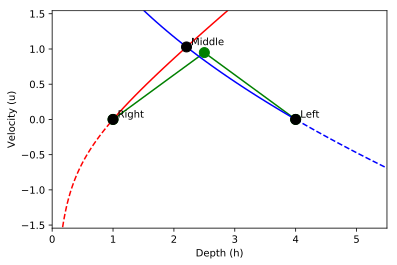

In [4]:
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states)

The next example illustrates the exactness property for isolated shocks.  Here we have chosen $q_l$ and $q_r$ such that they are related by a single 2-shock (up to rounding errors).

In [5]:
h_l = 2.20698770767; h_r = 1.
u_l = 2.27057814896/h_l; hu_r = 0.

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_roe(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states],
                                                 [ex_speeds, speeds],
                                                 [ex_reval, reval],
                                                 [ex_wave_types, wave_types],
                                                 #['Exact','Roe with fix','Roe w/o fix'],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

### RJL comment:

<font color='red'>Impossible to tell that there's a red curve under the right-going green curve in the x-t plot. Confusing.

In the first plot, the speed of the 1-wave appears different for the Roe solution and the exact solution, but this is unimportant since the 1-wave has zero strength.

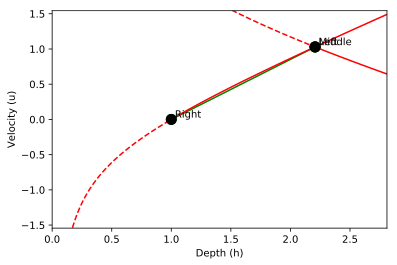

In [6]:
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states)

### Entropy fix

As discussed previously, the use of an entropy-violating discontinuity in place of a rarefaction can be problematic in the case of a transonic rarefaction.  For the Roe solver, we can again apply an entropy fix, splitting the single discontinuity into two waves, to avoid this problem.  Several different entropy fixes have been proposed; here we focus on one that is quite general and effective in practice.

Suppose that $\lambda_1(q_l) < 0$ while $\lambda_1(q_m)>0$.  In this case, it appears that the 1-wave should be a transonic rarefaction.  We take the 1-wave $\wave^1$ of the Roe solver, with speed $s_1$, and split it into two waves, $\wave^1_l = \alpha^1_l r_1$ and $\wave^1_r = \alpha^1_r r_1$, with speeds $\lambda_1(q_l), \lambda_1(q_m)$.  Two requirements determine the strength of these waves.  First, the total jump across them should be equal to the jump across the original wave:

$$\wave^1_l + \wave^1_r = \wave^1.$$

Second, we must maintain conservation:

$$\lambda_1(q_l) \wave^1_l + \lambda_1(q_m) \wave^1_r = s^1 \wave^1.$$

This leads to

\begin{align*}
\wave^1_l & = \frac{\lambda^1(q_m)-s_1}{\lambda^1(q_m)-\lambda^1(q_l)}\wave^1 \\
\wave^1_r & = \frac{s_1 - \lambda^1(q_l)}{\lambda^1(q_m)-\lambda^1(q_l)}\wave^1.
\end{align*}

We can check in a similar way for a transonic 2-rarefaction, and modify the 2-wave accordingly.  Note that only one of the two characteristic fields can be transonic in the Riemann solution for the shallow water equations.

This entropy fix is implemented in the solver below.

In [7]:
def shallow_water_roe_with_efix(q_l, q_r, grav=1., efix=True):
    """
    Approximate Roe solver for the shallow water equations,
    with entropy fix.
    """
    
    h_l = q_l[0]
    hu_l = q_l[1]
    u_l = hu_l/h_l
    h_r = q_r[0]
    hu_r = q_r[1]
    u_r = hu_r/h_r
    
    delta = q_r - q_l
    
    # Roe averages
    h_hat = (h_r + h_l)/2.
    u_hat = (np.sqrt(h_r)*u_r + np.sqrt(h_l)*u_l) / (np.sqrt(h_r) + np.sqrt(h_l))
    c_hat = np.sqrt(grav*h_hat)
    
    s1 = u_hat - c_hat
    s2 = u_hat + c_hat
    
    alpha1 = ( (u_hat+c_hat)*delta[0] - delta[1])/(2*c_hat)
    #alpha2 = (-(u_hat-c_hat)*delta[0] + delta[1])/(2*c_hat)
    
    h_m = q_l[0] + alpha1
    hu_m = q_l[1] + alpha1 * (u_hat - c_hat)
    u_m = hu_m/h_m
    q_m = np.array([h_m, hu_m])
        
    transonic = None
    if efix:
        # Check if either wave appears transonic
        lambda_1_l = u_l - np.sqrt(grav*h_l)
        lambda_1_m = u_m - np.sqrt(grav*h_m)
        lambda_2_m = u_m + np.sqrt(grav*h_m)
        lambda_2_r = u_r + np.sqrt(grav*h_r)
        
        if lambda_1_l < 0 < lambda_1_m: # 1-wave appears transonic
            transonic = 1
        elif lambda_2_m < 0 < lambda_2_r: # 2-wave appears transonic
            transonic = 2
    
    if transonic == 1:
        beta = (lambda_1_m - s1)/(lambda_1_m - lambda_1_l)
        alpha1_l = beta*alpha1
        #alpha_1_r = (1-beta)*alpha1
        h_m_new = q_l[0] + alpha1_l
        hu_m_new = q_l[1] + alpha1_l * (u_hat-c_hat)
        q_m_new = np.array([h_m_new, hu_m_new])
        states = np.column_stack([q_l,q_m_new,q_m,q_r])
        speeds = [lambda_1_l, lambda_1_m, s2]
        wave_types = ['contact']*3
        
        def reval(xi):
            h_out  = (xi<speeds[0])*states[0,0] + \
                     (speeds[0]<=xi)*(xi<speeds[1])*states[0,1] + \
                     (speeds[1]<=xi)*(xi<speeds[2])*states[0,2] + \
                     (speeds[2]<=xi)*states[0,3]
            hu_out = (xi<speeds[0])*states[1,0] + \
                     (speeds[0]<=xi)*(xi<speeds[1])*states[1,1] + \
                     (speeds[1]<=xi)*(xi<speeds[2])*states[1,2] + \
                     (speeds[2]<=xi)*states[1,3]
            return h_out, hu_out
        
    elif transonic == 2:
        beta = (lambda_2_r - s2)/(lambda_2_r - lambda_2_m)
        #alpha2_l = beta*alpha2
        alpha2_r = (1-beta)*alpha2
        h_m_new = q_r[0] - alpha2_r
        hu_m_new = q_r[1] - alpha2_r*(u_hat+c_hat)
        q_m_new = np.array([h_m_new, hu_m_new])
        states = np.column_stack([q_l,q_m,q_m_new,q_r])
        speeds = [s1,lambda_2_, lambda_2_r]
        wave_types = ['contact']*3

        def reval(xi):
            h_out  = (xi<speeds[0])*states[0,0] + \
                     (speeds[0]<=xi)*(xi<speeds[1])*states[0,1] + \
                     (speeds[1]<=xi)*(xi<speeds[2])*states[0,2] + \
                     (speeds[2]<=xi)*states[0,3]
            hu_out = (xi<speeds[0])*states[1,0] + \
                     (speeds[0]<=xi)*(xi<speeds[1])*states[1,1] + \
                     (speeds[1]<=xi)*(xi<speeds[2])*states[1,2] + \
                     (speeds[2]<=xi)*states[1,3]
            return h_out, hu_out
        
    else:    
        states = np.column_stack([q_l,q_m,q_r])
        speeds = [s1, s2]
        wave_types = ['contact','contact']
    
        def reval(xi):
            h_out  = (xi<s1)*h_l + (s1<=xi)*(xi<=s2)*h_m + (s2<xi)*h_r
            hu_out = (xi<s1)*hu_l + (s1<=xi)*(xi<=s2)*hu_m + (s2<xi)*hu_r
            return h_out, hu_out
    
    return states, speeds, reval, wave_types

Here are some examples of problems with transonic rarefactions, showing the behavior of the solver.

In [8]:
h_l = 1; h_r = 1
u_l = 0.5; u_r = 2

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_roe_with_efix(q_l, q_r)
no_efix_states, no_efix_speeds, no_efix_reval, no_efix_wave_types = shallow_water_roe(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states, no_efix_states],
                                                 [ex_speeds, speeds, no_efix_speeds],
                                                 [ex_reval, reval, no_efix_reval],
                                                 [ex_wave_types, wave_types, no_efix_wave_types],
                                                 #['Exact','Roe with fix','Roe w/o fix'],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

### RJL comment:
<font color='red'>
Need legend explaining that black = exact, yellow = without efix, green = with efix

Is it confusing that above we plot hu vs. x but in the phase plane we plot u vs. h (rather than hu vs. h).  In general should we plot h-hu plane?

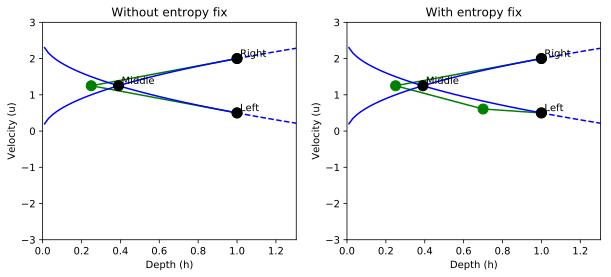

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=no_efix_states,ax=ax[0])
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states,ax=ax[1])
ax[0].set_title('Without entropy fix')
ax[1].set_title('With entropy fix');

In [10]:
h_l = 4; h_r = 1
u_l = 1; u_r = 1

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_roe_with_efix(q_l, q_r)
no_efix_states, no_efix_speeds, no_efix_reval, no_efix_wave_types = shallow_water_roe(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states, no_efix_states],
                                                 [ex_speeds, speeds, no_efix_speeds],
                                                 [ex_reval, reval, no_efix_reval],
                                                 [ex_wave_types, wave_types, no_efix_wave_types],
                                                 #['Exact','Roe with fix','Roe w/o fix'],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

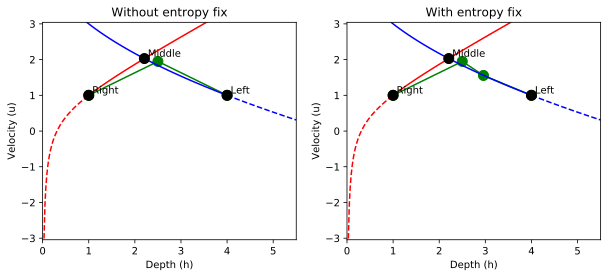

In [11]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=no_efix_states,ax=ax[0])
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states,ax=ax[1])
ax[0].set_title('Without entropy fix')
ax[1].set_title('With entropy fix');

### Positivity

In the shallow water system, it is both physically and mathematically essential that the depth remain non-negative.  Unfortunately, as the next example shows, the Roe solver does not always guarantee this.

In [12]:
h_l = 1; h_r = 1
u_l = -1.5; u_r = 1.5

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_roe_with_efix(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states],
                                                 [ex_speeds, speeds],
                                                 [ex_reval, reval],
                                                 [ex_wave_types, wave_types],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

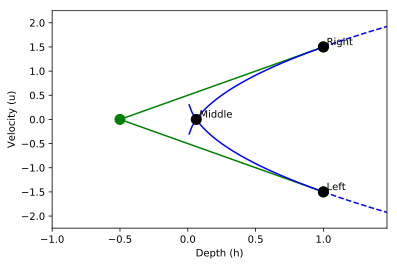

In [13]:
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states, hmin = -1)

In fact, this is a feature of all linearized Riemann solvers: for some Riemann problems, they will produce negative intermediate states.  The HLL solver described next does guarantee a positive solution for all initial data.

## HLL solver

### Derivation and implementation

Recall that an HLL approximate solver is based on a fictitious solution consisting of two waves (discontinuities) with a single intermediate state $q_m$ between them.  The waves are thus

\begin{align}
\wave_1 & = q_m - q_l \\
\wave_2 & = q_r - q_m.
\end{align}

The middle state is determined by the requirement of conservation:

\begin{align}
s_1 \wave_1 + s_2 \wave_2 & = f(q_r) - f(q_l),
\end{align}

which can be solved for $q_m$ to find

\begin{align}  \label{SWA:hll_middle_state}
q_m = \frac{f(q_r) - f(q_l) - s_2 q_r + s_1 q_l}{s_1 - s_2}.
\end{align}

The key remaining ingredient is the choice of the wave speeds $s_1, s_2$.  These should approximate the wave speeds appearing in the true Riemann solution.  In general, it is desirable for the purpose of stability that the speeds used be approximations of the fastest (left- and right-going) waves in the Riemann solution.  Indeed, in the original paper of Harten, Lax, and van Leer (cite) it was proposed to use lower and upper bounds on the true wave speeds.  However, overestimating the wave speeds leads to increased diffusion, and various refinements to the choice of wave speeds were subsequently proposed.

For the shallow water system, the 1-wave speed is always less than or equal to the 2-wave speed.  If the 1-wave is a rarefaction, then the minimum wave velocity is given simply by $\lambda_1(q_l)$, the characteristic speed at the left edge of the 1-rarefaction fan.  If the left-going wave speed is a shock, then minimum wave velocity is the shock speed.  We cannot determine the shock speed exactly without solving the Riemann problem -- just what we hope to avoid.  Instead, we can use an approximate shock speed based on the Roe average:

$$\hat{s}_1 = \hat{u} - \hat{c}.$$

Since we don't know whether the 1-wave should be a shock or a rarefaction, we use a lower bound on these two speeds, by taking their minimum:

$$s_1 = \min\left(\lambda_1(q_l), \hat{u}-\hat{c}\right).$$

Similarly, the second wave speed is given by

$$s_2 = \max\left(\lambda_2(q_r), \hat{u}+\hat{c}\right).$$

This completes the definition of the solver. Notice that if the states $q_r, q_l$ are connected by a single 2-shock, then the value of $s_2$ will be the exact shock speed (since the Roe speed is exact in this case, and the shock speed will be faster than the characteristic speed ahead of it).  Furthermore, by substituting the Rankine-Hugoniot conditions into \eqref{SWA:hll_middle_state}, one sees that the the middle state in this case will be $q_m = q_l$.  Thus the HLL solver gives the exact solution for this case.  Similarly, it yields the exact solution when the initial states are connected by just a 1-shock.  It shares this nice property with the Roe solver (as long as the wave speeds are chosen as just described).

### RJL comment:
<font color='red'>
This choice of $s_1$ and $s_2$ using the Roe averages is actually the HLLE solver.  The original HLL solver did not use this, but just recommended using lower and upper bounds on all characteristics speeds.

In [14]:
def shallow_water_hll(q_l, q_r, grav=1.):
    """
    HLL approximate solver for the shallow water equations.
    """
    h_l = q_l[0]
    hu_l = q_l[1]
    u_l = hu_l/h_l
    h_r = q_r[0]
    hu_r = q_r[1]
    u_r = hu_r/h_r
        
    # Roe averages
    h_hat = (h_r + h_l)/2.
    u_hat = (np.sqrt(h_r)*u_r + np.sqrt(h_l)*u_l) / (np.sqrt(h_r) + np.sqrt(h_l))
    c_hat = np.sqrt(grav*h_hat)

    lambda_1_l = u_l - np.sqrt(grav*h_l)
    lambda_2_r = u_r + np.sqrt(grav*h_r)
    
    s1 = min(lambda_1_l, u_hat - c_hat)
    s2 = max(lambda_2_r, u_hat + c_hat)
    
    h_m = (hu_r - hu_l - s2*h_r + s1*h_l)/(s1-s2)
    hu_m = (hu_r*u_r - hu_l*u_l + 0.5*grav*(h_r**2 - h_l**2) - s2*hu_r + s1*hu_l)/(s1-s2)
    q_m = np.array([h_m, hu_m])
    
    states = np.column_stack([q_l,q_m,q_r])
    speeds = [s1, s2]
    wave_types = ['contact','contact']
    
    def reval(xi):
        h_out  = (xi<s1)*h_l + (s1<=xi)*(xi<=s2)*h_m + (s2<xi)*h_r
        hu_out = (xi<s1)*hu_l + (s1<=xi)*(xi<=s2)*hu_m + (s2<xi)*hu_r
        return h_out, hu_out
    
    return states, speeds, reval, wave_types

### Examples

In [15]:
# Dam-break example
h_l = 4; h_r = 1
u_l = 0; u_r = 0

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_hll(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states],
                                                 [ex_speeds, speeds],
                                                 [ex_reval, reval],
                                                 [ex_wave_types, wave_types],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

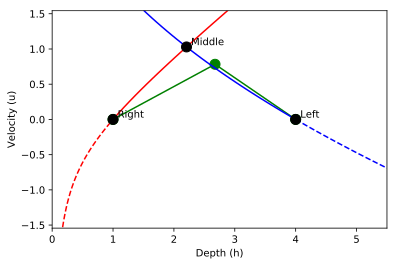

In [16]:
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states)

In [17]:
# Isolated 2-shock example
h_l = 2.20698770767; h_r = 1.
u_l = 2.27057814896/h_l; hu_r = 0.

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_hll(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states],
                                                 [ex_speeds, speeds],
                                                 [ex_reval, reval],
                                                 [ex_wave_types, wave_types],
                                                 #['Exact','Roe with fix','Roe w/o fix'],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

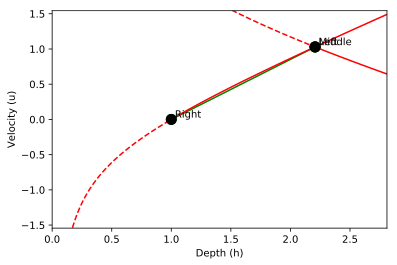

In [18]:
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states)

In [19]:
# Transonic rarefaction example a
h_l = 1; h_r = 1
u_l = 0.5; u_r = 2

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_hll(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states],
                                                 [ex_speeds, speeds],
                                                 [ex_reval, reval],
                                                 [ex_wave_types, wave_types],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

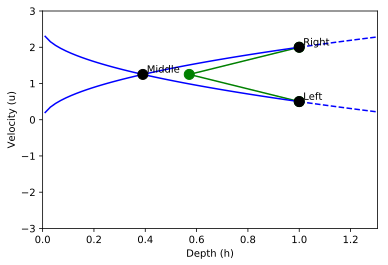

In [20]:
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states)

Notice that, by design, the HLL wave always lies exactly on the leading edge of a rarefaction wave, when compared to the true solution.

### Entropy and positivity

It can be shown that the HLL solver always preserves positivity and does not require an entropy fix.  Both of these properties result in part from the fact that the HLL solver is more diffusive than the Roe solver.

### RJL comment:
<font color='red'>
Is this true for all HLL solvers? Presumably depends on choice of $s_1$ and $s_2$.  It's true for HLLE.

In [25]:
# Transonic rarefaction example b
h_l = 4; h_r = 1
u_l = 1; u_r = 1

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_hll(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states],
                                                 [ex_speeds, speeds],
                                                 [ex_reval, reval],
                                                 [ex_wave_types, wave_types],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

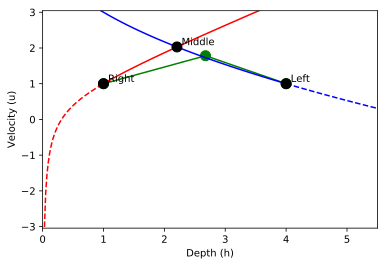

In [22]:
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states)

In [23]:
h_l = 1; h_r = 1
u_l = -1.5; u_r = 1.5

hu_l = h_l*u_l; hu_r = h_r*u_r
q_l = np.array([h_l, hu_l]); q_r = np.array([h_r, hu_r])
ex_states, ex_speeds, ex_reval, ex_wave_types = shallow_water.exact_riemann_solution(q_l,q_r)
states, speeds, reval, wave_types = shallow_water_hll(q_l, q_r)

plot_function = riemann_tools.make_plot_function([ex_states, states],
                                                 [ex_speeds, speeds],
                                                 [ex_reval, reval],
                                                 [ex_wave_types, wave_types],
                                                 variable_names=shallow_water.conserved_variables)
interact(plot_function, t=widgets.FloatSlider(min=0,max=.9,step=.1));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.9), Output()), _dom_classes=('widget-interact',))

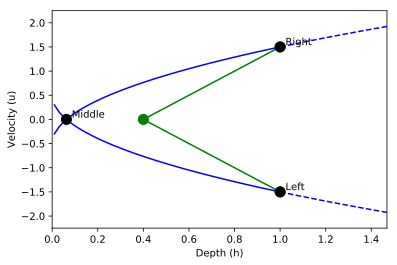

In [24]:
shallow_water.phase_plane_plot(q_l,q_r,g=1.,y_axis='u',approx_states=states)